# Fraud detection : ML project 

### Column info

##### Invoice data

* consommation_level = consumption of electricity or gas (kwh/m^3). Each consumption level has a threshold, after which someone moves to the next level.
* old index/new index = the measurment of electricity or gas at a given time.
* months_number = number of months between each measurement
* counter_coeffiecient = is an additionnal coefficient to be added when standard consumpution is exceeded / Indicates the power consumption
* reading_remarque = Reading remarque is notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* counter_statue = status of the counter (works/does not work /on hold et.c)
* tarif_type = information regarding how much tax you pay.
* counter_type = the type of consumption (Electricity or gas)
* counter_code = a unique code for the Elec or gas counter

##### Client data

* creation_date = When the contract enacted
* client_catg = the type of contract that a client has
* target = whether the client is stealing from the company(1) or not (0)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#load all the data
train_invoice = pd.read_csv("data/train/invoice_train.csv", parse_dates=['invoice_date'])
train_client = pd.read_csv("data/train/client_train.csv" , parse_dates=['creation_date'])
test_invoice = pd.read_csv("data/test/invoice_test.csv", parse_dates=['invoice_date'])
test_client = pd.read_csv("data/test/client_test.csv" , parse_dates=['creation_date'])

/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_46351/4112656046.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_invoice = pd.read_csv("data/train/invoice_train.csv", parse_dates=['invoice_date'])
/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_46351/4112656046.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_client = pd.read_csv("data/train/client_train.csv" , parse_dates=['creation_date'])
/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_46351/4112656046.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_client = pd.read_csv("data/test/client_test.csv" , parse_dates=['creation_date'])


### Working on the train data only

In [5]:
train_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
train_client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0
2,62,train_Client_10,11,301,1986-03-13,0.0
3,69,train_Client_100,11,105,1996-07-11,0.0
4,62,train_Client_1000,11,303,2014-10-14,0.0


In [7]:
#checking for the shape of the train data
print(train_invoice.shape, train_client.shape)


(4476749, 16) (135493, 6)


In [8]:
#getting info 
train_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  int64         
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  int64         
 3   region         135493 non-null  int64         
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.2+ MB


In [9]:
train_client.describe().T

,count,mean,min,25%,50%,75%,max,std
disrict,135493.0,63.511222,60.0,62.0,62.0,69.0,69.0,3.3544
client_catg,135493.0,11.512506,11.0,11.0,11.0,11.0,51.0,4.423761
region,135493.0,206.159809,101.0,103.0,107.0,307.0,399.0,104.207044
creation_date,135493,2002-10-01 18:45:16.001564544,1977-02-05 00:00:00,1994-01-12 00:00:00,2005-09-19 00:00:00,2012-04-04 00:00:00,2019-09-10 00:00:00,NaN
target,135493.0,0.055841,0.0,0.0,0.0,0.0,1.0,0.229614


In [10]:
train_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        object        
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
dtypes: datetime64[ns](1), int64(12), object(3)
memory usage: 546.5+ MB


In [11]:
train_invoice.describe().T

,count,mean,min,25%,50%,75%,max,std
invoice_date,4476749,2013-03-18 07:42:34.444128768,1977-06-09 00:00:00,2010-01-19 00:00:00,2013-07-10 00:00:00,2016-09-03 00:00:00,2019-12-07 00:00:00,NaN
tarif_type,4476749.0,20.128039,8.0,11.0,11.0,40.0,45.0,13.472556
counter_number,4476749.0,123058699065.183319,0.0,121108.0,494561.0,1115161.0,27981145458733.0,1657267274261.926758
counter_code,4476749.0,172.48843,0.0,5.0,203.0,207.0,600.0,133.8871
reading_remarque,4476749.0,7.321702,5.0,6.0,8.0,9.0,413.0,1.571654
counter_coefficient,4476749.0,1.00304,0.0,1.0,1.0,1.0,50.0,0.308347
consommation_level_1,4476749.0,410.979495,0.0,79.0,274.0,600.0,999910.0,757.307998
consommation_level_2,4476749.0,109.322476,0.0,0.0,0.0,0.0,999073.0,1220.123335
consommation_level_3,4476749.0,20.306204,0.0,0.0,0.0,0.0,64492.0,157.423938
consommation_level_4,4476749.0,52.925881,0.0,0.0,0.0,0.0,547946.0,875.472477


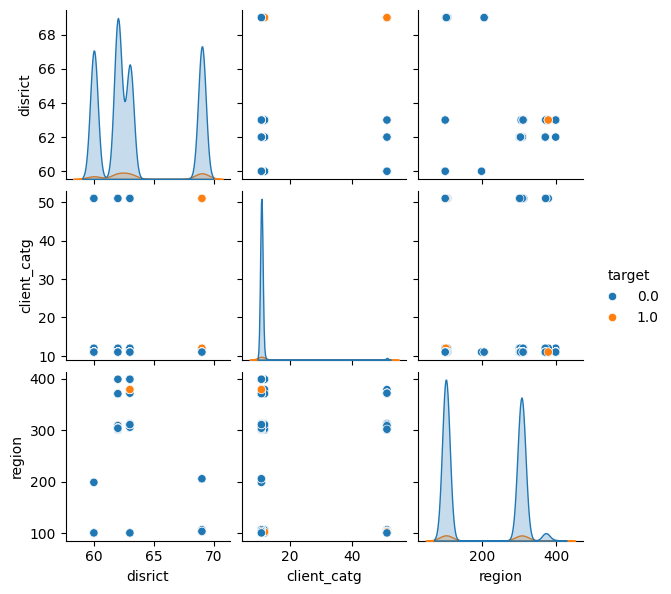

In [12]:
sns.pairplot(train_client, hue="target", height=2)

In [13]:
#function to clean the dataset 
def client_cleaning(df):
    #rename the district column
    df.rename(columns = {"disrict" : "district"}, inplace = True)
     # Converting region column to the category
    df["region"] = df["region"].astype("object")
     # Converting district column to the category
    df["district"] = df["district"].astype("object")
     # Converting client category column to the category
    df["client_catg"] = df["client_catg"].astype("object")
    # Converting creation_date column to date time
    df['creation_date'] = pd.to_datetime(df['creation_date'],
                                               errors='coerce',
                                               infer_datetime_format=True).dt.date
    # Getting unique values on the client train data
    for col in df.columns:
        print(f"Number of unique values in {col} - {df[col].nunique()}")
    return df

In [14]:
client_cleaning(train_client)

Number of unique values in district - 4
Number of unique values in client_id - 135493
Number of unique values in client_catg - 3
Number of unique values in region - 25
Number of unique values in creation_date - 8088
Number of unique values in target - 2


/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_46351/1790379626.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['creation_date'] = pd.to_datetime(df['creation_date'],


,district,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0.0
1,69,train_Client_1,11,107,2002-05-29,0.0
2,62,train_Client_10,11,301,1986-03-13,0.0
3,69,train_Client_100,11,105,1996-07-11,0.0
4,62,train_Client_1000,11,303,2014-10-14,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,2004-07-26,0.0
135489,63,train_Client_99996,11,311,2012-10-25,0.0
135490,63,train_Client_99997,11,311,2011-11-22,0.0
135491,60,train_Client_99998,11,101,1993-12-22,0.0


In [15]:
#checking for null values
train_client.isnull().sum()

district         0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [16]:
train_invoice.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [17]:
train_client.duplicated().sum()

0

In [18]:
# Checking duplicates on client id
train_duplicates = train_client.duplicated(subset = 'client_id', keep = False)
# Checking the duplicates
train_client[train_duplicates]

,district,client_id,client_catg,region,creation_date,target


In [19]:
#cleaning the train invoice
def client_cleaning(df): 
    df['invoice_date'] = pd.to_datetime(df['invoice_date'],
                                               errors='coerce',
                                               infer_datetime_format=True).dt.date
    for col in df.columns:
        print(f"Number of unique values in {col} - {df[col].nunique()}")
    return df
    

In [20]:
client_cleaning(train_invoice)

/var/folders/pp/kcbw8ksn7g9_pjm4p84cj6ym0000gn/T/ipykernel_46351/2825993920.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['invoice_date'] = pd.to_datetime(df['invoice_date'],


Number of unique values in client_id - 135493
Number of unique values in invoice_date - 8275
Number of unique values in tarif_type - 17
Number of unique values in counter_number - 201893
Number of unique values in counter_statue - 16
Number of unique values in counter_code - 42
Number of unique values in reading_remarque - 8
Number of unique values in counter_coefficient - 16
Number of unique values in consommation_level_1 - 8295
Number of unique values in consommation_level_2 - 12576
Number of unique values in consommation_level_3 - 2253
Number of unique values in consommation_level_4 - 12075
Number of unique values in old_index - 155648
Number of unique values in new_index - 157980
Number of unique values in months_number - 1370
Number of unique values in counter_type - 2


,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [21]:
# Checking the columns that are duplicated
invoice_train_duplicates =train_invoice.duplicated()
train_invoice[invoice_train_duplicates]

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
951893,train_Client_125864,2011-12-12,11,101545,5,413,6,1,0,0,0,0,13680,13680,2,ELEC
1755798,train_Client_25894,2010-07-13,40,6986740,5,5,6,1,0,0,0,0,0,0,2,GAZ
2137999,train_Client_3636,2012-01-18,40,312650,5,5,6,1,0,0,0,0,623,623,2,GAZ
2163374,train_Client_37069,2010-10-11,11,5284,5,413,6,1,0,0,0,0,99429,99429,2,ELEC
2433919,train_Client_44407,2008-02-28,11,66921,5,203,6,1,0,0,0,0,0,0,2,ELEC
2805729,train_Client_54609,2010-04-06,11,200912,5,207,6,1,0,0,0,0,0,0,2,ELEC
3260191,train_Client_66981,2006-07-17,11,132701,5,420,6,1,0,0,0,0,5946,5946,2,ELEC
3260198,train_Client_66981,2006-07-17,11,132701,5,420,6,1,0,0,0,0,5946,5946,2,ELEC
3394719,train_Client_7066,2014-10-28,40,4463323,5,5,6,1,0,0,0,0,80,80,2,GAZ
3462929,train_Client_72519,2013-01-21,11,246464,5,203,6,1,0,0,0,0,2954,2954,2,ELEC


In [22]:
#dropping duplicates 
train_invoice.drop_duplicates(inplace=True)

In [23]:
train_invoice.duplicated().sum()

0

In [24]:
values = {'ELEC':0,'GAZ':1}
train_invoice['counter_type'] =train_invoice['counter_type'].map(values)
train_invoice['counter_type'].value_counts()

counter_type
0    3079398
1    1397340
Name: count, dtype: int64

In [25]:
aggs = {}
aggs["consommation_level_1"] = ["mean"]
aggs["consommation_level_2"] = ["mean"]
aggs["consommation_level_3"] = ["mean"]
aggs["consommation_level_4"] = ["mean"]
aggs_transaction = train_invoice.groupby(["client_id"]).agg(aggs)
aggs_transaction.columns = ['_'.join(col).strip() for col in aggs_transaction.columns.values]
aggs_transaction.reset_index(inplace=True)
df = (train_invoice.groupby('client_id')
      .size()
      .reset_index(name='transactions_count'))
agg_trans = pd.merge(df, aggs_transaction, on="client_id", how="left")


In [26]:
train = pd.merge(train_client, agg_trans, on="client_id", how="left")

In [27]:
train.head()

,district,client_id,client_catg,region,creation_date,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,60,train_Client_0,11,101,1994-12-31,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,train_Client_1,11,107,2002-05-29,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,train_Client_10,11,301,1986-03-13,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,train_Client_100,11,105,1996-07-11,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,train_Client_1000,11,303,2014-10-14,0.0,14,663.714286,104.857143,117.357143,36.714286


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   district                   135493 non-null  object 
 1   client_id                  135493 non-null  object 
 2   client_catg                135493 non-null  object 
 3   region                     135493 non-null  object 
 4   creation_date              135493 non-null  object 
 5   target                     135493 non-null  float64
 6   transactions_count         135493 non-null  int64  
 7   consommation_level_1_mean  135493 non-null  float64
 8   consommation_level_2_mean  135493 non-null  float64
 9   consommation_level_3_mean  135493 non-null  float64
 10  consommation_level_4_mean  135493 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 11.4+ MB


## EDA 

In [40]:
train['target'].value_counts()

target
0.0    127927
1.0      7566
Name: count, dtype: int64

<Figure size 1600x800 with 0 Axes>

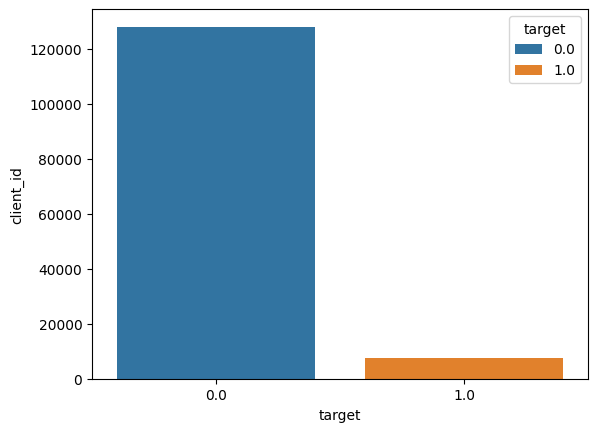

<Figure size 1600x800 with 0 Axes>

In [35]:
client_target = train.groupby(["target"]).client_id.count().reset_index()
sns.barplot(data=client_target, x= "target", y="client_id", hue= "target", palette=['#1f77b4', '#ff7f0e'])
plt.figure(figsize=(16,8))
#unbalanced data 

<Figure size 1000x500 with 0 Axes>

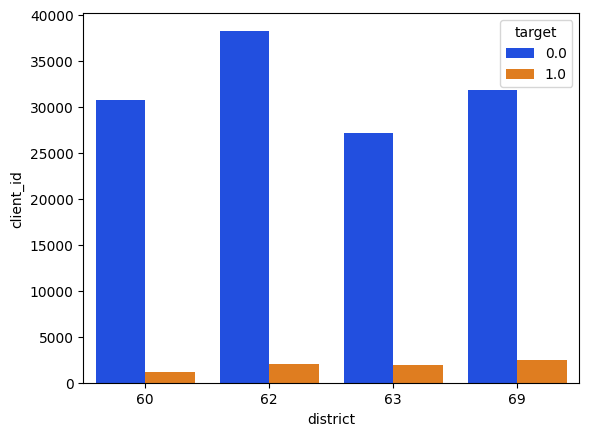

<Figure size 1000x500 with 0 Axes>

In [39]:
# Checking which district has many fraduent activities
district_clients = train.groupby(["target", "district"]).client_id.count().reset_index()
sns.barplot(data=district_clients, x= "district", y="client_id", hue="target", palette='bright')
plt.figure(figsize=(10,5))

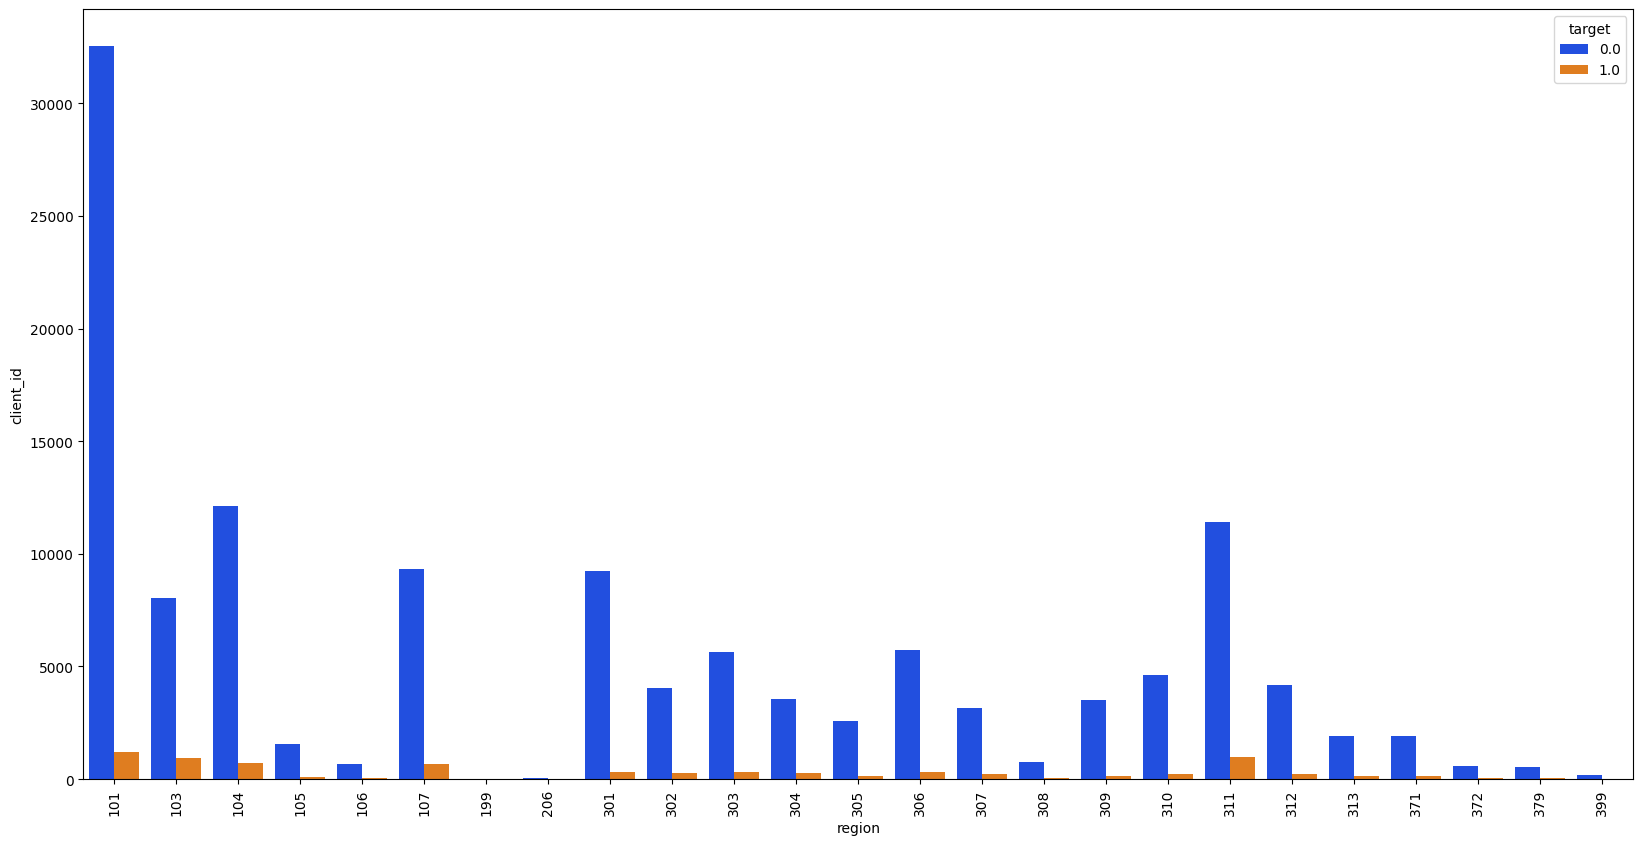

In [56]:
# Set the figure size before creating the plot
plt.figure(figsize=(20, 10))

# Checking which district has many fraudulent activities
region_clients = train.groupby(["target", "region"]).client_id.count().reset_index()

# Create the bar plot
sns.barplot(data=region_clients, x="region", y="client_id", hue="target", palette='bright')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90);

Text(0.5, 1.0, 'Consommation Level 4')

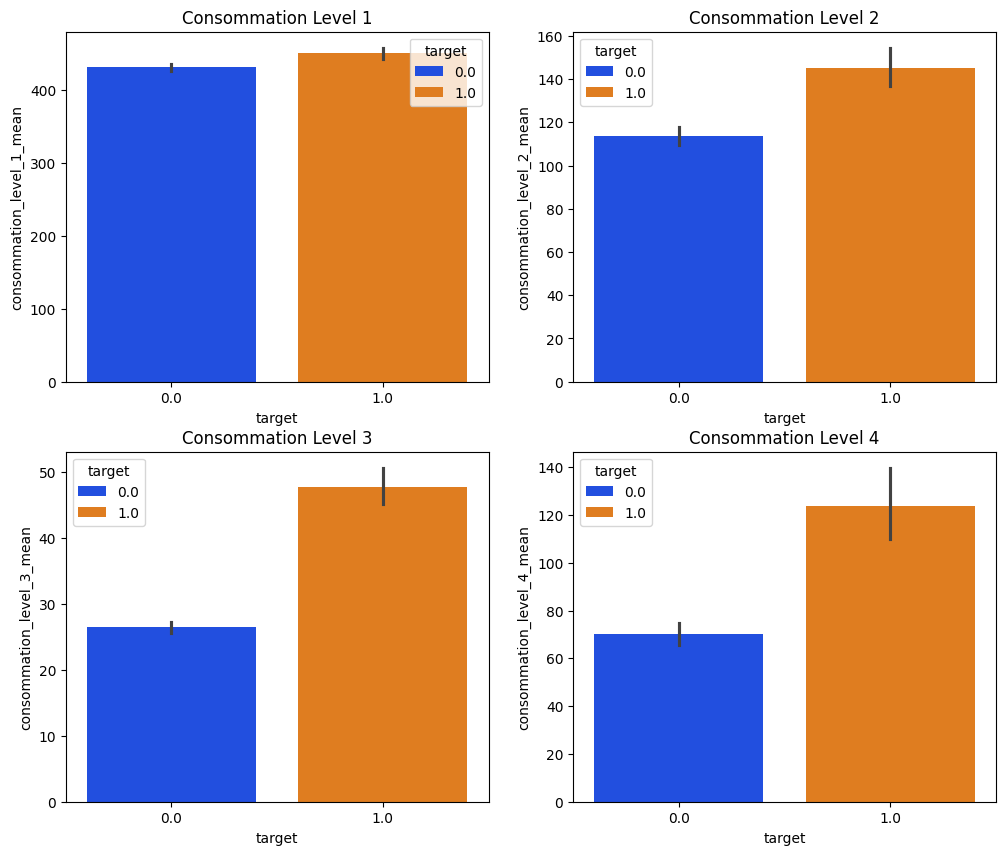

In [47]:
# Set the figure size
plt.figure(figsize=(12, 10))

# Create the first subplot (Top-left)
plt.subplot(2, 2, 1)
sns.barplot(x="target", y="consommation_level_1_mean", data=train, hue="target", palette='bright')
plt.title('Consommation Level 1')

# Create the second subplot (Top-right)
plt.subplot(2, 2, 2)
sns.barplot(x="target", y="consommation_level_2_mean", data=train, hue="target", palette='bright')
plt.title('Consommation Level 2')

# Create the third subplot (Bottom-left)
plt.subplot(2, 2, 3)
sns.barplot(x="target", y="consommation_level_3_mean", data=train, hue="target", palette='bright')
plt.title('Consommation Level 3')

# Create the fourth subplot (Bottom-right)
plt.subplot(2, 2, 4)
sns.barplot(x="target", y="consommation_level_4_mean", data=train, hue="target", palette='bright')
plt.title('Consommation Level 4')

## Split the data and Feature Engineering 

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [58]:
# Dropping useless columns
train.drop(['creation_date','client_id'],axis=1,inplace=True)

In [59]:
# Determining the predictor variables
X = train.drop(["target"],axis = 1)
# Determining the target variables
y = train.target
# Splitting the data to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2,random_state =42)

In [60]:
#categorical columns 
cat_col = ["district", "client_catg", "region"]
x_train_cat = pd.get_dummies(X_train, columns=cat_col)
x_test_cat = pd.get_dummies(X_test, columns=cat_col)

In [61]:
x_train_cat

,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,district_60,district_62,district_63,district_69,client_catg_11,...,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399
50789,40,273.300000,203.200000,0.000000,0.000000,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
8156,75,144.933333,26.546667,0.000000,0.000000,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
134312,9,516.000000,0.000000,0.000000,0.000000,False,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
9149,30,218.766667,86.633333,52.866667,0.000000,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
58245,30,288.800000,0.000000,0.000000,0.000000,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,37,505.837838,16.216216,19.189189,18.216216,False,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
119879,5,2.400000,0.000000,0.000000,0.000000,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
103694,4,642.000000,46.500000,0.000000,0.000000,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
131932,22,313.409091,0.000000,0.000000,0.000000,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [63]:
#Scaler 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_cat)
x_test_scaled = scaler.fit_transform(x_test_cat)

In [64]:
from imblearn.combine import SMOTEENN

In [65]:
smote = SMOTEENN()
# Fitting smoteen
X_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

## Model to train : it's a classification model 
- Logistic regression.
- Decision tree. 
- Random forest. 
- LGBMClassifier 


In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_curve, recall_score

### Logistic regression 

In [67]:
# Instantiating logistic regression
lr = LogisticRegression(random_state=42)
# Fitting the model
lr.fit(X_train_resampled, y_train_resampled)


LogisticRegression(random_state=42)

In [71]:
# Predicting on training and test sets
lr_train_pred = lr.predict(X_train_resampled)
lr_test_pred = lr.predict(x_test_scaled)

# Evaluating the model on the training set
lr_train_auc = roc_auc_score(y_train_resampled, lr_train_pred)
# Evaluating the model on the test set
lr_test_auc = roc_auc_score(y_test, lr_test_pred)

In [72]:
# Evaluating the balanced classes data
print(f'baseline logreg Train AUC - {lr_train_auc} \nbaseline logreg Test AUC - {lr_test_auc}')

baseline logreg Train AUC - 0.7100169746276518 
baseline logreg Test AUC - 0.6527170595296461


Accuracy : 0.5960736558544596
Recall : 0.7167519181585678
Balanced Accuracy : 0.6527170595296461
F1 Score : 0.1700030330603579
AUC Score:  0.6527170595296461


<Axes: >

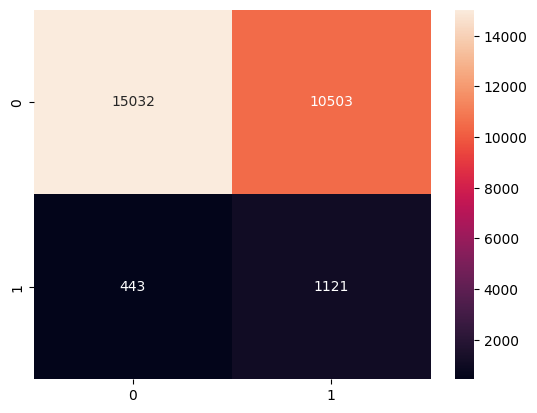

In [128]:
print('Accuracy :', accuracy_score(y_test,lr_test_pred))
print('Recall :', recall_score(y_test,lr_test_pred))
print('Balanced Accuracy :', balanced_accuracy_score(y_test,lr_test_pred))
print('F1 Score :', f1_score(y_test,lr_test_pred))
print('AUC Score: ', roc_auc_score(y_test,lr_test_pred))

cm = confusion_matrix(y_test,lr_test_pred)

sns.heatmap(cm, annot=True, fmt='d')

### Decision tree 

In [74]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

#Instantiate the model 
dt = DecisionTreeClassifier()
# Fitting the model
dt.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier()

In [76]:
dt_train_pred = dt.predict(X_train_resampled)
dt_test_pred = dt.predict(x_test_scaled)

dt_train_auc = roc_auc_score(y_train_resampled, dt_train_pred)
dt_test_auc = roc_auc_score(y_test, dt_test_pred)


# Evaluating the balanced classes data
print(f'baseline decision tree Train AUC - {dt_train_auc} \nbaseline decision treeTest AUC - {dt_test_auc}')

baseline decision tree Train AUC - 1.0 
baseline decision treeTest AUC - 0.5268339879519459


Accuracy : 0.628620982324071
Recall : 0.4117647058823529
Balanced Accuracy : 0.5268339879519459
F1 Score : 0.11346018322762509
AUC Score:  0.5268339879519459


<Axes: >

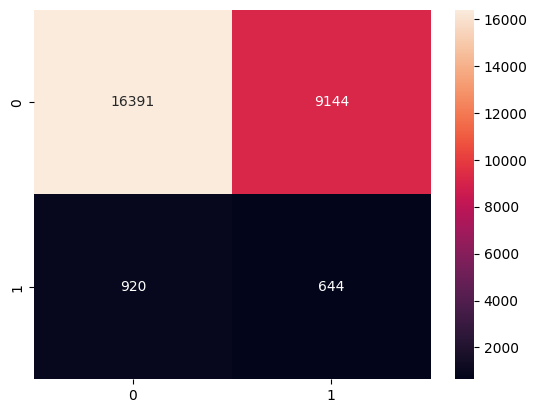

In [130]:
print('Accuracy :', accuracy_score(y_test,dt_test_pred))
print('Recall :', recall_score(y_test,dt_test_pred))
print('Balanced Accuracy :', balanced_accuracy_score(y_test,dt_test_pred))
print('F1 Score :', f1_score(y_test,dt_test_pred))
print('AUC Score: ', roc_auc_score(y_test,dt_test_pred))

cm = confusion_matrix(y_test,dt_test_pred)

sns.heatmap(cm, annot=True, fmt='d')

### Random forest 

In [77]:
from sklearn.ensemble import RandomForestClassifier
# Instantiating random forest classifier
rf = RandomForestClassifier(random_state=42)
# Fitting the model to the training data+
rf.fit(X_train_resampled, y_train_resampled)
# Evaluating random forest baseline model
rf_train_pred = rf.predict(X_train_resampled)
rf_test_pred = rf.predict(x_test_scaled)
rf_train_auc = roc_auc_score(y_train_resampled,rf_train_pred)
rf_test_auc = roc_auc_score(y_test,rf_test_pred)
print(f'Train AUC - {rf_train_auc} \nTest AUC - {rf_test_auc}')

Train AUC - 1.0 
Test AUC - 0.6172862131460904


In [82]:
# # Parameter grid 
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'max_features': ['auto', 'sqrt']
}

# Instantiating GridSearchCV
rf_clf = GridSearchCV(estimator = rf,scoring='roc_auc',
                          param_grid = rf_param_grid)
# Fitting using grid search
rf_clf.fit(X_train_resampled,y_train_resampled)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [86]:
# # Instantiating GridSearchCV
rf_clf = GridSearchCV(estimator = rf,scoring='roc_auc',
                          param_grid = rf_param_grid)
# Fitting using grid search
rf_clf.fit(X_train_resampled,y_train_resampled)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 5],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [87]:
# Getting the best hyperparameters for decision tree classifier
rf_clf.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

In [90]:
#Instantiating the random forest model with the best hyperparameters 
best_rf = RandomForestClassifier(random_state=42, 
                                 max_depth=None, 
                                 max_features='sqrt', 
                                 n_estimators=200) 
#fitting the model 
best_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_estimators=200, random_state=42)

In [91]:
# Evaluating the model 
best_rf_train_pred = best_rf.predict(X_train_resampled)
best_rf_test_pred = best_rf.predict(x_test_scaled)
best_rf_train_auc = roc_auc_score(y_train_resampled,best_rf_train_pred)
best_rf_test_auc = roc_auc_score(y_test,best_rf_test_pred)
print(f'Train AUC - {best_rf_train_auc} \nTest AUC - {best_rf_test_auc}')

Train AUC - 1.0 
Test AUC - 0.612382057223499


Accuracy : 0.7276283257684786
Recall : 0.4820971867007673
Balanced Accuracy : 0.612382057223499
F1 Score : 0.16964787940150747
AUC Score:  0.612382057223499


<Axes: >

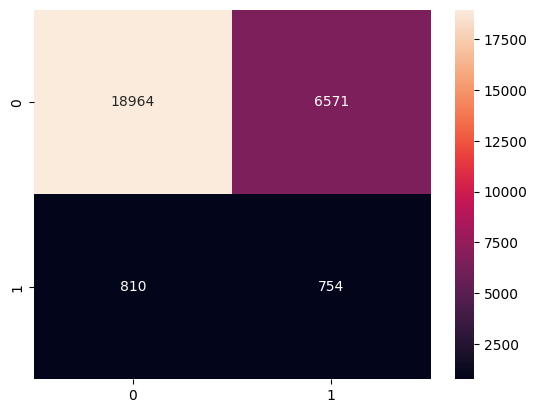

In [131]:
print('Accuracy :', accuracy_score(y_test,best_rf_test_pred))
print('Recall :', recall_score(y_test,best_rf_test_pred))
print('Balanced Accuracy :', balanced_accuracy_score(y_test,best_rf_test_pred))
print('F1 Score :', f1_score(y_test,best_rf_test_pred))
print('AUC Score: ', roc_auc_score(y_test,best_rf_test_pred))

cm = confusion_matrix(y_test,best_rf_test_pred)

sns.heatmap(cm, annot=True, fmt='d')

### LightGBM

In [93]:
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 


In [97]:
import warnings
warnings.filterwarnings("ignore")

In [119]:
import pickle
# Deserialize the object from the binary file
with open('X_train_resampled.pkl', 'wb') as file:
    pickle.dump(X_train_resampled, file)

In [121]:
testggg=pickle.load(open("X_train_resampled.pkl", 'rb'))
testggg

array([[-0.11617673, -0.18747855, -0.14754141, ..., -0.06895825,
        -0.06683264, -0.03518183],
       [-0.72805056, -0.42047787, -0.14754141, ..., -0.06895825,
        -0.06683264, -0.03518183],
       [ 0.41921287,  0.54438379,  1.12258404, ..., -0.06895825,
        -0.06683264, -0.03518183],
       ...,
       [-0.23021293, -0.1755306 , -0.05729742, ..., -0.06895825,
        -0.06683264, -0.03518183],
       [-0.05701487,  0.02809471, -0.12513584, ..., -0.06895825,
        -0.06683264, -0.03518183],
       [ 0.26624441, -0.0673213 , -0.11684583, ..., -0.06895825,
        -0.06683264, -0.03518183]])

In [115]:
with open('y_train_resampled.pkl', 'wb') as file:
    pickle.dump(y_train_resampled, file)

In [116]:
with open('x_test_scaled.pkl', 'wb') as file:
    pickle.dump(x_test_scaled, file)

In [117]:
with open('y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

In [123]:
y_train_resampled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
153078    1.0
153079    1.0
153080    1.0
153081    1.0
153082    1.0
Name: target, Length: 153083, dtype: float64

In [98]:
lgbm = LGBMClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)

lgbm_train_pred = lgbm.predict(X_train_resampled)
lgbm_test_pred = lgbm.predict(x_test_scaled)

lgbm_train_auc = roc_auc_score(y_train_resampled, lgbm_train_pred)
lgbm_test_auc = roc_auc_score(y_test, lgbm_test_pred)

print(f'Train AUC - {lgbm_train_auc } \nTest AUC - {lgbm_test_auc}')

[LightGBM] [Info] Number of positive: 82379, number of negative: 70704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 153083, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538133 -> initscore=0.152828
[LightGBM] [Info] Start training from score 0.152828
Train AUC - 0.8810818772550664 
Test AUC - 0.5953841625530777


In [124]:
best_lgb = LGBMClassifier(random_state=42,n_estimators=830,
                     num_leaves=454, max_depth=61,
                     learning_rate=0.006,
                     min_split_gain=0.006,
                     bagging_freq=8).fit(X_train_resampled,y_train_resampled)

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Info] Number of positive: 82379, number of negative: 70704
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 153083, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538133 -> initscore=0.152828
[LightGBM] [Info] Start training from score 0.152828


In [125]:
# Predicting the value of y using the model for both training and testing set
best_lgb_train_pred = best_lgb.predict(X_train_resampled)
best_lgb_test_pred = best_lgb.predict(x_test_scaled)

# Evaluating the model using area under the curve
best_lgb_train_auc = roc_auc_score(y_train_resampled,best_lgb_train_pred)
best_lgb_test_auc = roc_auc_score(y_test,best_lgb_test_pred)

print(f'Train AUC - {best_lgb_train_auc} \nTest AUC - {best_lgb_test_auc}')

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Train AUC - 0.952696199140033 
Test AUC - 0.5876741316391874


Accuracy : 0.4955533414517141
Recall : 0.6918158567774936
Balanced Accuracy : 0.5876741316391874
F1 Score : 0.13666792977137804
AUC Score:  0.5876741316391874


<Axes: >

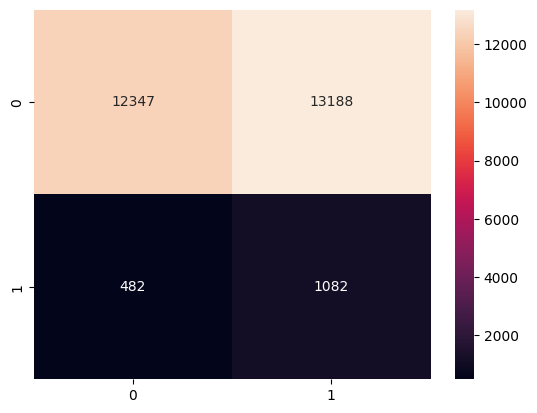

In [132]:
print('Accuracy :', accuracy_score(y_test,best_lgb_test_pred))
print('Recall :', recall_score(y_test,best_lgb_test_pred))
print('Balanced Accuracy :', balanced_accuracy_score(y_test,best_lgb_test_pred))
print('F1 Score :', f1_score(y_test,best_lgb_test_pred))
print('AUC Score: ', roc_auc_score(y_test,best_lgb_test_pred))

cm = confusion_matrix(y_test,best_lgb_test_pred)

sns.heatmap(cm, annot=True, fmt='d')

### Gradient boost 

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
# Instantiating GradientBoostingClassifier baseline model and fitting the model to the set
gb = GradientBoostingClassifier(random_state=42).fit(X_train_resampled,y_train_resampled)

# Predicting the value of y using the model for both training and testing set
gb_train_pred = gb.predict(X_train_resampled)
gb_test_pred = gb.predict(x_test_scaled)

# Evaluating the model using area under the curve
gb_train_auc = roc_auc_score(y_train_resampled,gb_train_pred)
gb_test_auc = roc_auc_score(y_test,gb_test_pred)
print(f'Train AUC - {gb_train_auc} \nTest AUC - {gb_test_auc}')

Train AUC - 0.8053423776501942 
Test AUC - 0.6531282598429416


Accuracy : 0.5968485921989741
Recall : 0.7167519181585678
Balanced Accuracy : 0.6531282598429415
F1 Score : 0.17027417027417027
AUC Score:  0.6531282598429416


<Axes: >

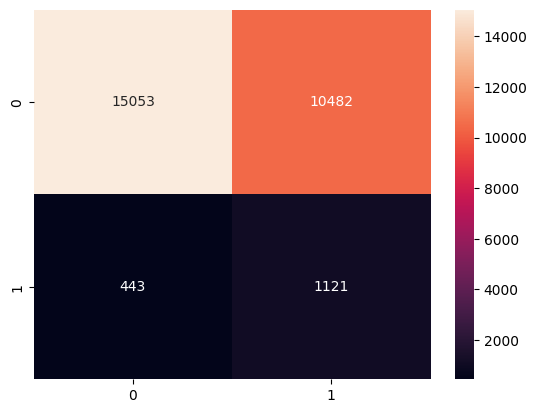

In [138]:
print('Accuracy :', accuracy_score(y_test,gb_test_pred))
print('Recall :', recall_score(y_test,gb_test_pred))
print('Balanced Accuracy :', balanced_accuracy_score(y_test,gb_test_pred))
print('F1 Score :', f1_score(y_test,gb_test_pred))
print('AUC Score: ', roc_auc_score(y_test,gb_test_pred))

cm = confusion_matrix(y_test,gb_test_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Predicting the value of y using the model for both training and testing set
best_lgb_train_pred = best_lgb.predict(X_train_resampled)
best_lgb_test_pred = best_lgb.predict(x_test_scaled)

# Evaluating the model using area under the curve
best_lgb_train_auc = roc_auc_score(y_train_resampled,best_lgb_train_pred)
best_lgb_test_auc = roc_auc_score(y_test,best_lgb_test_pred)

print(f'Train AUC - {best_lgb_train_auc} \nTest AUC - {best_lgb_test_auc}')

In [137]:
# Create a dictionary to store the AUC scores
models = {'Model': ['Baseline Logistic Regression', 'Decision Tree', 
                    'Random Forest',
                    'Tuned Random Forest','Gradient Boosting Classifier',
                    'LGBMClassifier','Tuned LGBMClassifier'],
          'Train AUC': [lr_train_auc, dt_train_auc, 
                        rf_train_auc,best_rf_train_auc,
                        gb_train_auc,lgbm_train_auc,best_lgb_train_auc],
          'Test AUC': [lr_test_auc, dt_test_auc, 
                      rf_test_auc,best_rf_test_auc,
                       gb_test_auc,lgbm_test_auc,best_lgb_test_auc]}

# Convert the dictionary to a Pandas DataFrame
auc_df = pd.DataFrame(models)

# Set the 'Model' column as the index of the DataFrame
auc_df = auc_df.set_index('Model')

# Compute the difference between train and test AUC scores
auc_df['AUC Difference'] = auc_df['Train AUC'] - auc_df['Test AUC']

# Sort the values by AUC Difference in descending order
auc_df = auc_df.sort_values('AUC Difference', ascending=True)

# Print the DataFrame
auc_df

,Train AUC,Test AUC,AUC Difference
Model,,,
Baseline Logistic Regression,0.710017,0.652717,0.057300
Gradient Boosting Classifier,0.805342,0.653128,0.152214
LGBMClassifier,0.881082,0.595384,0.285698
Tuned LGBMClassifier,0.952696,0.587674,0.365022
Random Forest,1.000000,0.617286,0.382714
Tuned Random Forest,1.000000,0.612382,0.387618
Decision Tree,1.000000,0.526834,0.473166


In [140]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
affine                       2.4.0
aggdraw                      1.3.18.post0
aiofiles                     22.1.0
aiohappyeyeballs             2.3.4
aiohttp                      3.10.1
aiosignal                    1.3.1
aiosqlite                    0.20.0
altair                       5.0.1
annotated-types              0.7.0
anyio                        4.4.0
appnope                      0.1.4
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
astor                        0.8.1
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.15.0
beautifulsoup4               4.12.3
bleach                       6.1.0
blinker                      1.8.2
branca                       0.7.2
cachetools                   